# Capstone Project 1
## Bitcoin(BTC) and Litecoin(LTC) Prices vs Their Google Keyword Search Trend. 

- This project will explore the relationship between the closing price of two popular cryptocurrencies (bitcoin(BTC) and litecoin(LTC)) and the frequency of the Google search terms "bitcoin price" and "litecoin price" respectively. A third search trend ("donald trump") is used to validate the method of comparing the Google search term trend for a cryptocurrency coin and its respective closing price. 
- The price data will be pulled from Coinbase using the "crycompare" python library.  This uses the Coinbase API to pull the most up-to-date coin information.  The Google search trend data will be obtained using the "pytrends" python library.  This uses some unofficial Google APIs to query the relative frequency, by week, of specific search terms.  
- Once all the data is in memory and cleaned, trends and correlations are explored in further detail.



In [1]:
%load_ext autoreload
%autoreload 2

#
# Imports.
#
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import Parallel, delayed
import operator
import matplotlib.pyplot as plt
from pytrends.request import TrendReq
from scipy import stats

from crycompare import *

%matplotlib inline

In [2]:
#
# Set the cutoff day.
#
cutoff_day = pd.to_datetime('2017-11-18', yearfirst=True)

#
# Obtain the price history (close, high, low, open) for bitcoin(BTC) using the crycompare library.
#
h = History()
btc_hist = h.histoDay('BTC', 'USD', allData=True)
if btc_hist['Data']:
    df_btc = pd.DataFrame(btc_hist['Data'])
    df_btc['time'] = pd.to_datetime(df_btc['time'], unit='s')
    df_btc.index = df_btc['time']
    del df_btc['time']
    
#
# Filter out data newer than the cutoff day.
#
df_btc = pd.DataFrame(df_btc[:cutoff_day])
    
#
# Print the last 10 entries.
#
df_btc.tail(10)

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2017-11-09,7129.59,7457.12,7040.83,7444.36,126769.90,9.159639e+08
2017-11-10,6565.80,7318.97,6406.05,7129.59,222001.18,1.513421e+09
2017-11-11,6339.86,6821.50,6197.87,6565.80,135719.07,8.780969e+08
2017-11-12,5878.13,6490.53,5493.64,6339.87,269832.87,1.629165e+09
2017-11-13,6522.45,6760.15,5828.34,5878.09,178340.89,1.135256e+09
2017-11-14,6597.06,6728.59,6419.18,6522.45,96502.09,6.346050e+08
2017-11-15,7283.22,7330.06,6596.94,6597.06,131120.23,9.229595e+08
2017-11-16,7853.68,7964.64,7119.17,7283.02,133937.80,1.010131e+09
2017-11-17,7699.95,8000.19,7534.70,7853.68,117347.03,9.175999e+08


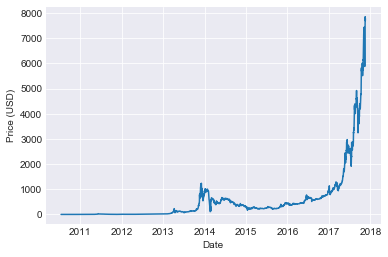

In [3]:
#
# Plot the closing price of bitcoin over time.
#
sns.set_style("darkgrid")
plt.plot(df_btc.close)
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.show()

In [4]:
#
# Obtain the price history (close, high, low, open) for litecoin(LTC) using the crycompare library.
#
ltc_hist = h.histoDay('LTC', 'USD', allData=True)
if ltc_hist['Data']:
    df_ltc = pd.DataFrame(ltc_hist['Data'])
    df_ltc['time'] = pd.to_datetime(df_ltc['time'], unit='s')
    df_ltc.index = df_ltc['time']
    del df_ltc['time']
    
#
# Filter out data newer than the cutoff day.
#
df_ltc = pd.DataFrame(df_ltc[:cutoff_day])
 
#
# Print the last 10 entries.
#
df_ltc.tail(10)

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2017-11-09,64.15,66.90,61.59,62.38,1507681.54,9.646737e+07
2017-11-10,58.99,65.75,56.02,64.15,1845061.12,1.122774e+08
2017-11-11,62.14,63.77,58.64,59.07,1169795.97,7.169117e+07
2017-11-12,58.54,62.26,56.73,62.14,1527653.80,9.054572e+07
2017-11-13,61.00,61.84,58.07,58.53,1058638.68,6.357822e+07
2017-11-14,62.13,63.41,60.12,61.00,936563.06,5.774014e+07
2017-11-15,63.16,76.10,62.08,62.13,934924.43,6.268327e+07
2017-11-16,70.70,72.50,62.50,63.15,1640431.26,1.088939e+08
2017-11-17,67.36,71.29,65.33,70.70,1728098.47,1.177016e+08


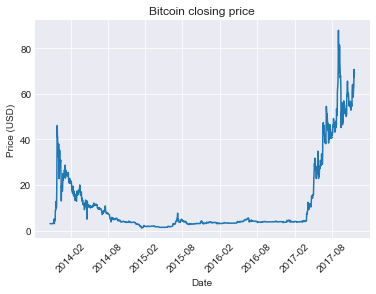

In [5]:
#
# Plot the closing price of litecoin over time.
#
sns.set_style("darkgrid")
plt.plot(df_ltc.close)
plt.xticks(rotation=45)
plt.title("Bitcoin closing price")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.show()

In [6]:
#
# Merge bitcoin and litecoin into a single dataframe.
#
df_coins = pd.concat([df_btc, df_ltc], axis=1)
df_coins.columns = ['btc_close','btc_high','btc_low','btc_open','btc_volfrom','btc_volto','ltc_close','ltc_high', \
                    'ltc_low','ltc_open','ltc_volfrom','ltc_volto']

#
# Print the first 10 entries.
#
df_coins.head(10)

,btc_close,btc_high,btc_low,btc_open,btc_volfrom,btc_volto,ltc_close,ltc_high,ltc_low,ltc_open,ltc_volfrom,ltc_volto
time,,,,,,,,,,,,
2010-07-17,0.04951,0.04951,0.04951,0.04951,20.00,0.9902,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-18,0.08584,0.08585,0.05941,0.04951,75.01,5.0900,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-19,0.08080,0.09307,0.07723,0.08584,574.00,49.6600,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-20,0.07474,0.08181,0.07426,0.08080,262.00,20.5900,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-21,0.07921,0.07921,0.06634,0.07474,575.00,42.2600,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-22,0.05050,0.08181,0.05050,0.07921,2160.00,129.7800,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-23,0.06262,0.06767,0.05050,0.05050,2402.50,141.0700,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-24,0.05454,0.06161,0.05049,0.06262,496.32,26.7300,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-25,0.05050,0.05941,0.05050,0.05454,1551.48,85.0600,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
#
# Print the dataframe info.
#
df_coins.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2682 entries, 2010-07-17 to 2017-11-18
Freq: D
Data columns (total 12 columns):
btc_close      2682 non-null float64
btc_high       2682 non-null float64
btc_low        2682 non-null float64
btc_open       2682 non-null float64
btc_volfrom    2682 non-null float64
btc_volto      2682 non-null float64
ltc_close      1487 non-null float64
ltc_high       1487 non-null float64
ltc_low        1487 non-null float64
ltc_open       1487 non-null float64
ltc_volfrom    1487 non-null float64
ltc_volto      1487 non-null float64
dtypes: float64(12)
memory usage: 272.4 KB


### From the dataframe info, we can see that there are more bitcoin entries than there are litecoin.  This is due to the fact that bitcoin was founded before litecoin and thus has more historical data.  Only the last two years worth of data will be explored so only the overlapping data between bitcoin and litecoin will be kept.

In [8]:
#
# Remove entries where the litecoin close is NaN.
#
df_coins = df_coins[np.isfinite(df_coins.ltc_close)]

#
# Print the dataframe info.
#
df_coins.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1487 entries, 2013-10-24 to 2017-11-18
Freq: D
Data columns (total 12 columns):
btc_close      1487 non-null float64
btc_high       1487 non-null float64
btc_low        1487 non-null float64
btc_open       1487 non-null float64
btc_volfrom    1487 non-null float64
btc_volto      1487 non-null float64
ltc_close      1487 non-null float64
ltc_high       1487 non-null float64
ltc_low        1487 non-null float64
ltc_open       1487 non-null float64
ltc_volfrom    1487 non-null float64
ltc_volto      1487 non-null float64
dtypes: float64(12)
memory usage: 151.0 KB


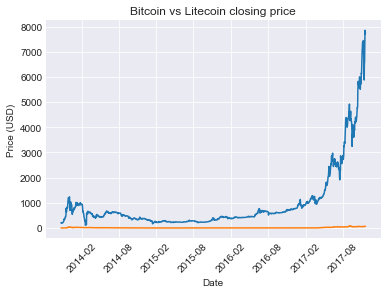

In [9]:
#
# Plot the two coins on the same plot.
#
sns.set_style("darkgrid")
plt.plot(df_coins.btc_close)
plt.plot(df_coins.ltc_close)
plt.xticks(rotation=45)
plt.title("Bitcoin vs Litecoin closing price")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.show()

### This plot isnt very helpful as the price difference between the two coins is too large to be shown without some normalization.

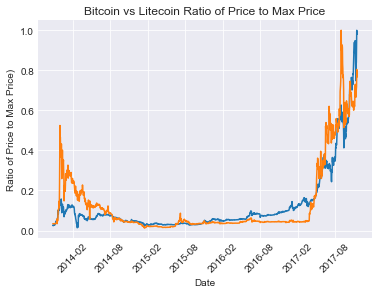

In [10]:
#
# Plot the two coins on the same plot but normalized.
#
sns.set_style("darkgrid")
plt.plot(df_coins.btc_close / df_coins.btc_close.max())
plt.plot(df_coins.ltc_close / df_coins.ltc_close.max())
plt.xticks(rotation=45)
plt.title("Bitcoin vs Litecoin Ratio of Price to Max Price")
plt.xlabel("Date")
plt.ylabel("Ratio of Price to Max Price)")
plt.show()

### Now that historical for both bitcoin and litecoin has been gathered and cleaned, the Google keyword search trend data needs to be obtained.  The search trend used for bitcoin is "bitcoin price" and the term used for litecoin is "litecoin price".  The search term "donald trump" is also used as a control for both groups as there should be very little correlation.

In [11]:
#
# Query Google for the keyword serach trend.
#
bitcoin = TrendReq()
litecoin = TrendReq()
trump = TrendReq()
btc_kwrd = ["bitcoin price"]
ltc_kwrd = ["litecoin price"]
trump_kwrd = ["donald trump"]
bitcoin.build_payload(btc_kwrd)
litecoin.build_payload(ltc_kwrd)
trump.build_payload(trump_kwrd)

#
# Obtain the intrest over time.  Resample by day and interpolate between points.
#
df_kwrd_bitcoin = bitcoin.interest_over_time()
df_kwrd_litecoin = litecoin.interest_over_time()
df_kwrd_trump = trump.interest_over_time()

#
# Print the last 10 entries for bitcoin to understand what the dataframe looks like.
#
df_kwrd_bitcoin.tail(10)

,bitcoin price,isPartial
date,,
2017-09-17,46,False
2017-09-24,35,False
2017-10-01,31,False
2017-10-08,52,False
2017-10-15,55,False
2017-10-22,57,False
2017-10-29,83,False
2017-11-05,89,False
2017-11-12,100,False


### It appears that the data from Google is by week.  However, the price data is by day.  To remedy this problem the Google trend data will be intrepolated between weeks to obtain a daily estimate.  Also, the 'isPartial' feature is not needed so should be removed from the dataframe to keep it uncluttered.

In [12]:
#
# Resample by day.
#
df_kwrd_bitcoin = df_kwrd_bitcoin.resample('D').interpolate(method='linear')
df_kwrd_litecoin = df_kwrd_litecoin.resample('D').interpolate(method='linear')
df_kwrd_trump = df_kwrd_trump.resample('D').interpolate(method='linear')

#
# Filter out anything newer than the cutoff day.
#
df_kwrd_bitcoin = pd.DataFrame(df_kwrd_bitcoin[:cutoff_day])
df_kwrd_litecoin = pd.DataFrame(df_kwrd_litecoin[:cutoff_day])
df_kwrd_trump = pd.DataFrame(df_kwrd_trump[:cutoff_day])

#
# Remove the 'isPartial' column.
#
del df_kwrd_bitcoin['isPartial']
del df_kwrd_litecoin['isPartial']
del df_kwrd_trump['isPartial']

In [13]:
#
# Print the last 10 entries in the bitcoin search dataframe.
#
df_kwrd_bitcoin.tail(10)

,bitcoin price
date,
2017-11-09,95.285714
2017-11-10,96.857143
2017-11-11,98.428571
2017-11-12,100.000000
2017-11-13,97.714286
2017-11-14,95.428571
2017-11-15,93.142857
2017-11-16,90.857143
2017-11-17,88.571429


In [14]:
#
# Print the last 10 entries in the litecoin search dataframe.
#
df_kwrd_litecoin.tail(10)

,litecoin price
date,
2017-11-09,62.285714
2017-11-10,61.857143
2017-11-11,61.428571
2017-11-12,61.000000
2017-11-13,63.428571
2017-11-14,65.857143
2017-11-15,68.285714
2017-11-16,70.714286
2017-11-17,73.142857


In [15]:
#
# Print the last 10 entries in the trump search dataframe.
#
df_kwrd_trump.tail(10)

,donald trump
date,
2017-11-09,5.000000
2017-11-10,5.000000
2017-11-11,5.000000
2017-11-12,5.000000
2017-11-13,4.857143
2017-11-14,4.714286
2017-11-15,4.571429
2017-11-16,4.428571
2017-11-17,4.285714


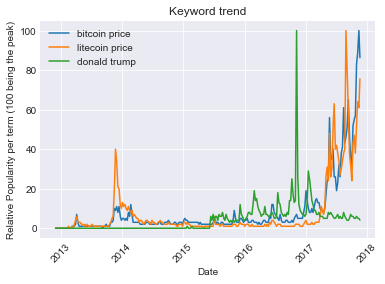

In [16]:
#
# Plot the two keywords on the same plot.
#
sns.set_style("darkgrid")
plt.plot(df_kwrd_bitcoin[btc_kwrd])
plt.plot(df_kwrd_litecoin[ltc_kwrd])
plt.plot(df_kwrd_trump[trump_kwrd])
plt.legend([btc_kwrd[0], ltc_kwrd[0], trump_kwrd[0]])
plt.xticks(rotation=45)
plt.title("Keyword trend")
plt.xlabel("Date")
plt.ylabel("Relative Popularity per term (100 being the peak)")
plt.show()

In [17]:
#
# Instert the keyword search data into the df_coins dataframe.
#
df_coins['btc_kwrd'] = df_kwrd_bitcoin[btc_kwrd[0]]
df_coins['ltc_kwrd'] = df_kwrd_litecoin[ltc_kwrd[0]]
df_coins['trump_kwrd'] = df_kwrd_trump[trump_kwrd[0]]

### The Google keyword search trend data is now properly in memory in one dataframe.  Some EDA will be performed to look for any trends that are worth further exploration.

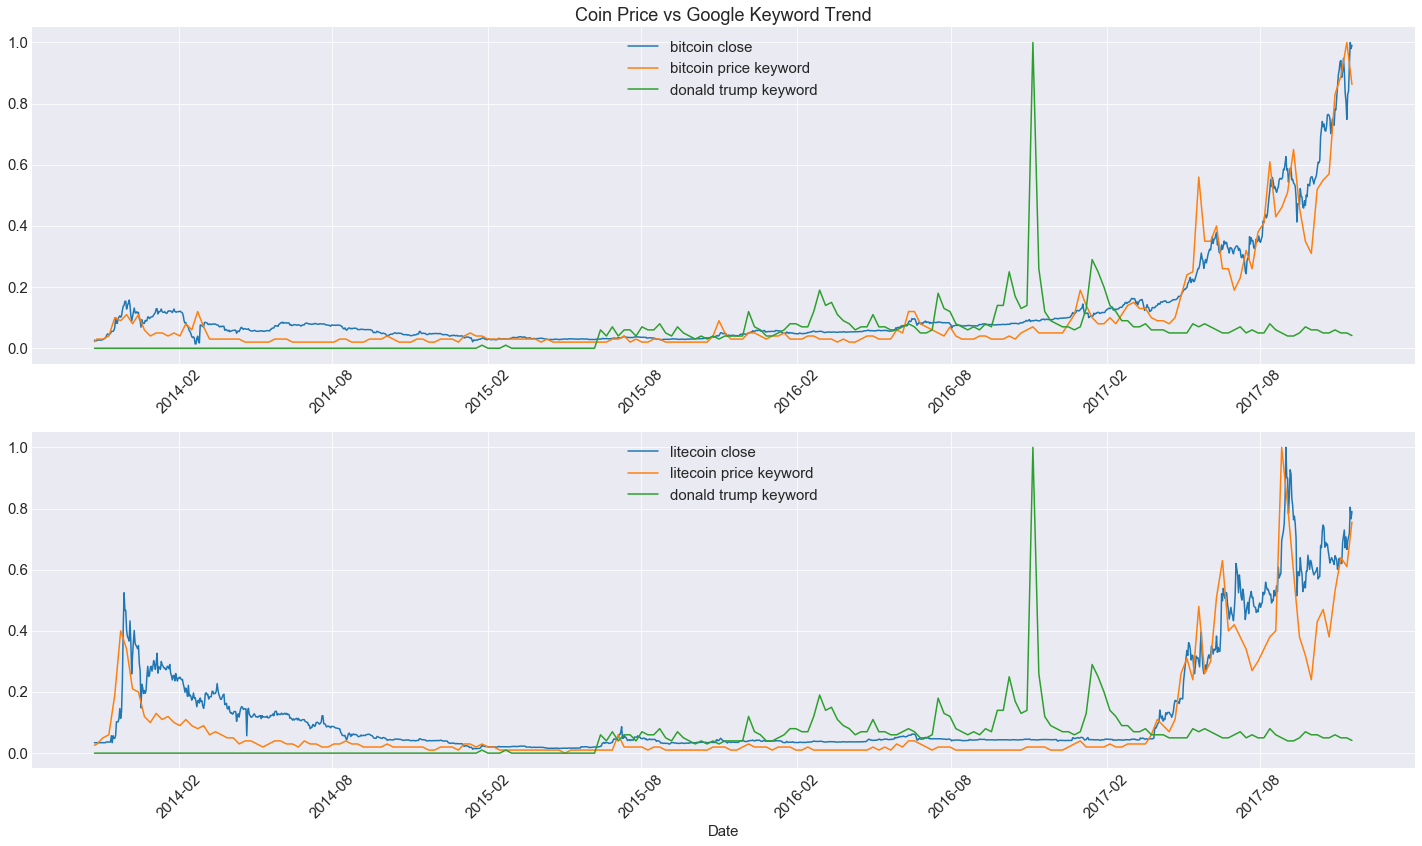

In [18]:
#
# Plot price vs keyword on the same plot.
#
plt.rcParams.update({'font.size': 15})
sns.set_style("darkgrid")
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(211)
plt.title("Coin Price vs Google Keyword Trend")
ax.plot(df_coins.btc_close / df_coins.btc_close.max())
ax.plot(df_coins.btc_kwrd / df_coins.btc_kwrd.max())
ax.plot(df_coins.trump_kwrd / df_coins.trump_kwrd.max())
ax.legend(["bitcoin close", btc_kwrd[0] + " keyword", trump_kwrd[0] + " keyword"],loc="upper center")
plt.xticks(rotation=45)
ax = fig.add_subplot(212)
ax.plot(df_coins.ltc_close / df_coins.ltc_close.max())
ax.plot(df_coins.ltc_kwrd / df_coins.ltc_kwrd.max())
ax.plot(df_coins.trump_kwrd / df_coins.trump_kwrd.max())
ax.legend(["litecoin close",  ltc_kwrd[0] + " keyword", trump_kwrd[0] + " keyword"],loc="upper center")
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.tight_layout()
plt.show()

### At first glance, the Google search trend data appears to be strongly correlated with the price of its respective coin.  Also, the data does not appear to be very interesting before the year 2016 so only that data will explored further.  First, lets plot only that data.

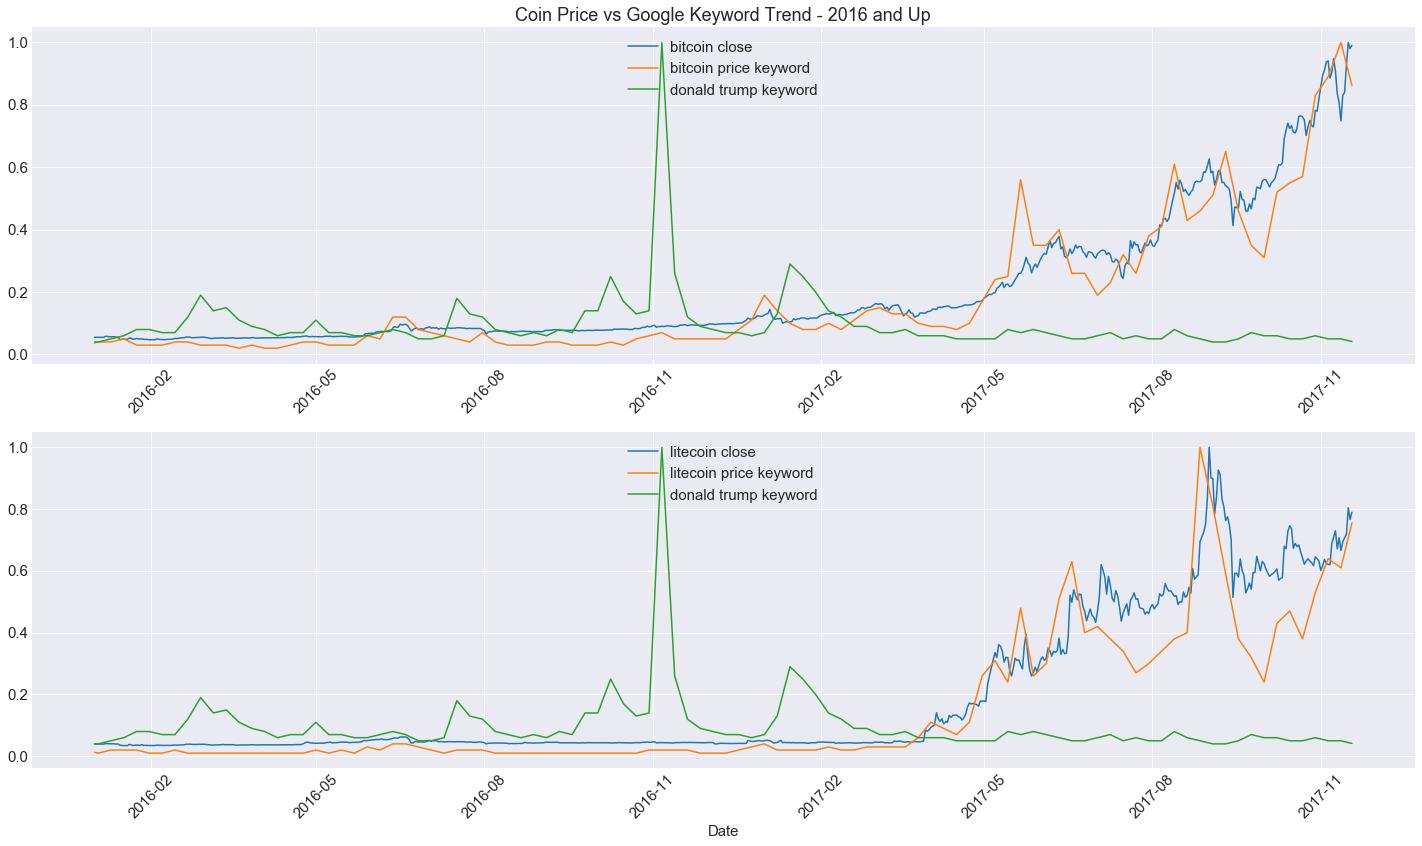

In [19]:
#
# Obtain 2016 and on.
#
year = '2016'

#
# Plot price vs keyword on the same plot for 2016 and on.
#
plt.rcParams.update({'font.size': 15})
sns.set_style("darkgrid")
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(211)
plt.title("Coin Price vs Google Keyword Trend - " + year + " and Up")
ax.plot(df_coins[year:].btc_close / df_coins[year:].btc_close.max())
ax.plot(df_coins[year:].btc_kwrd / df_coins[year:].btc_kwrd.max())
ax.plot(df_coins[year:].trump_kwrd / df_coins[year:].trump_kwrd.max())
ax.legend(["bitcoin close", btc_kwrd[0] + " keyword", trump_kwrd[0] + " keyword"],loc="upper center")
plt.xticks(rotation=45)
ax = fig.add_subplot(212)
ax.plot(df_coins[year:].ltc_close / df_coins[year:].ltc_close.max())
ax.plot(df_coins[year:].ltc_kwrd / df_coins[year:].ltc_kwrd.max())
ax.plot(df_coins[year:].trump_kwrd / df_coins[year:].trump_kwrd.max())
ax.legend(["litecoin close",  ltc_kwrd[0] + " keyword", trump_kwrd[0] + " keyword"],loc="upper center")
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.tight_layout()
plt.show()

### Observation:

- Now that we know what that data looks like, the pearson correlation coefficient will be examined to determine how strong correlated the two datasets are. At first glance it appears there is no correlation with the trump search trend and the coins closing price, but a strong correlation with the coin search price and its closing price.

- Lets explore this hunch further.

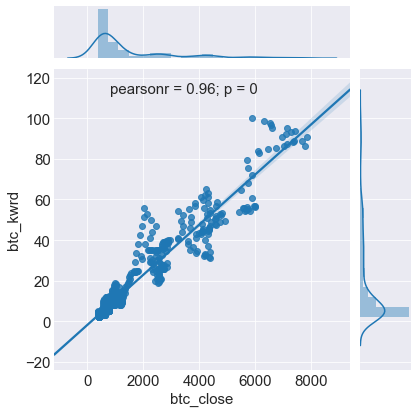

In [20]:
#
# How correlated are the search term frequency with the closing price for bitcoin?
#
sns.jointplot(x="btc_close", y="btc_kwrd", data=df_coins[year:], kind="reg")

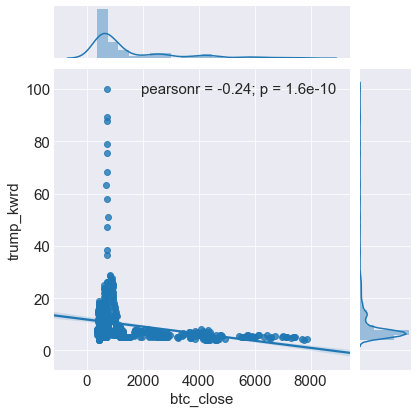

In [21]:
#
# How correlated are the trump search term frequency with the closing price for bitcoin?
#
sns.jointplot(x="btc_close", y="trump_kwrd", data=df_coins[year:], kind="reg")

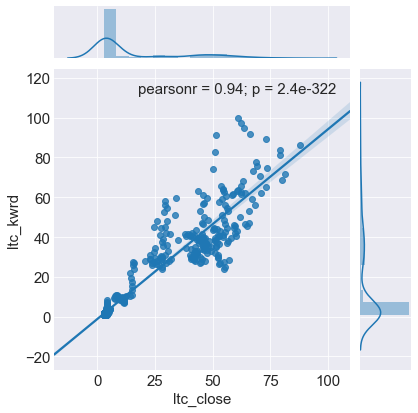

In [22]:
#
# How correlated are the search term frequency with the closing price for litecoin?
#
sns.jointplot(x="ltc_close", y="ltc_kwrd", data=df_coins[year:], kind="reg")

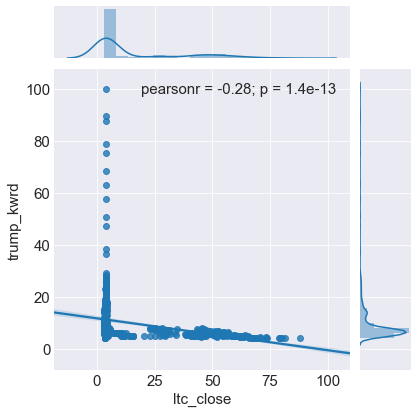

In [23]:
#
# How correlated are the trump search term frequency with the closing price for litecoin?
#
sns.jointplot(x="ltc_close", y="trump_kwrd", data=df_coins[year:], kind="reg")

### Result:

- The correlations are positive and very strong between the respective coin search frequency and the closing price for both bitcoin and litecoin.  It can also be seen that there is a slight negative correlation between the trump search trend and both bitcoin and litecoin. This correlation is, however, insignificant and will not be explored further as it's purpose was to validate the method used.  

### Question: 

- What happens if we shift the search term plot by one day, does the correlations increase, decrease or remain the same?

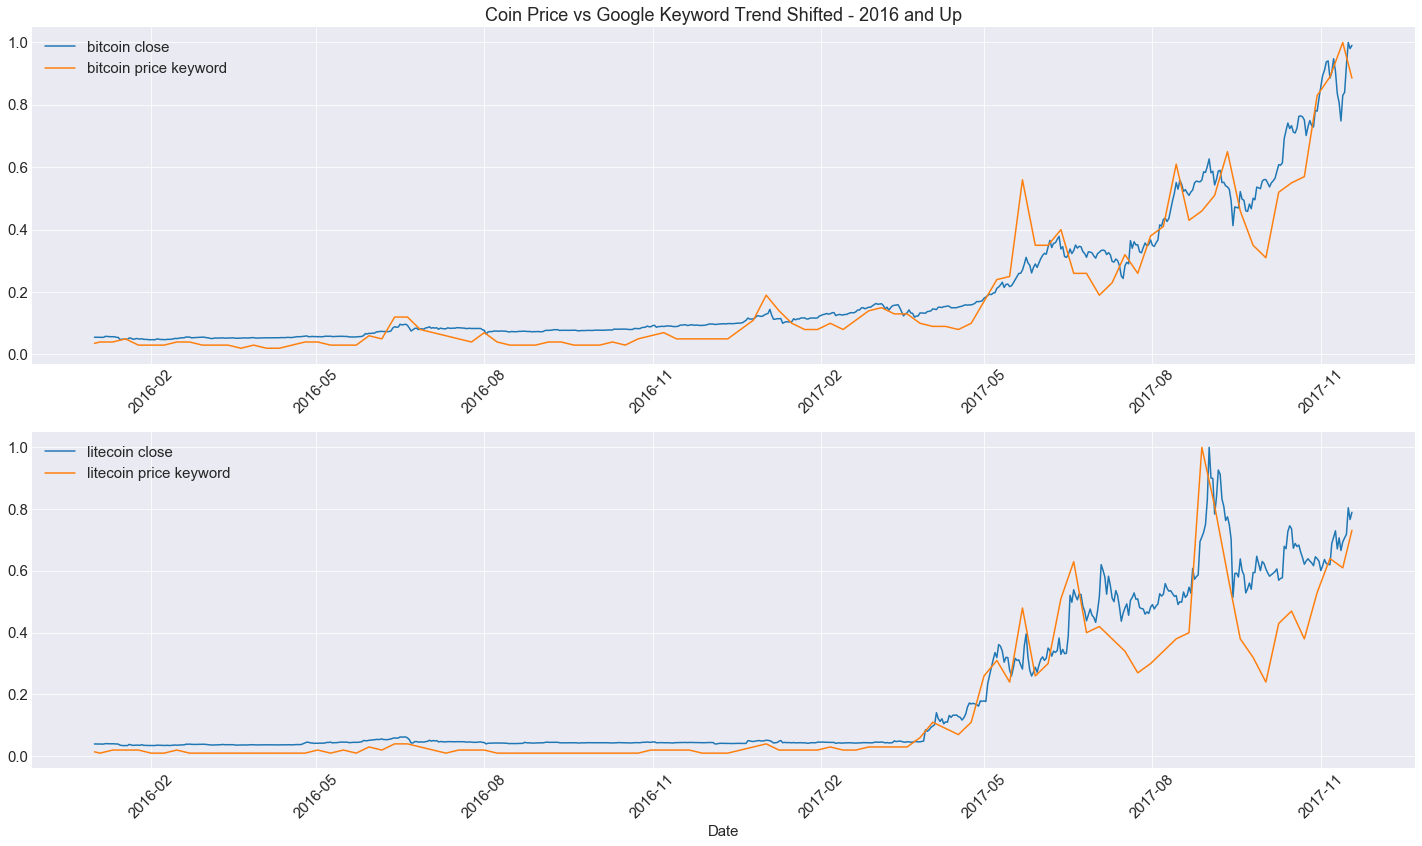

In [24]:
#
# Shift the search term vectors by a day.
#
df_coins_shifted = pd.DataFrame(df_coins)
df_coins_shifted.btc_kwrd = df_coins.btc_kwrd.shift(1)
df_coins_shifted.ltc_kwrd = df_coins.ltc_kwrd.shift(1)

#
# Plot price vs shifted keyword on the same plot for 2016 and on.
#
plt.rcParams.update({'font.size': 15})
sns.set_style("darkgrid")
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(211)
plt.title("Coin Price vs Google Keyword Trend Shifted - " + year + " and Up")
ax.plot(df_coins_shifted[year:].btc_close / df_coins_shifted[year:].btc_close.max())
ax.plot(df_coins_shifted[year:].btc_kwrd / df_coins_shifted[year:].btc_kwrd.max())
ax.legend(["bitcoin close", btc_kwrd[0] + " keyword"], loc="upper left")
plt.xticks(rotation=45)
ax = fig.add_subplot(212)
ax.plot(df_coins_shifted[year:].ltc_close / df_coins_shifted[year:].ltc_close.max())
ax.plot(df_coins_shifted[year:].ltc_kwrd / df_coins_shifted[year:].ltc_kwrd.max())
ax.legend(["litecoin close", ltc_kwrd[0] + " keyword"], loc="upper left")
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.tight_layout()
plt.show()

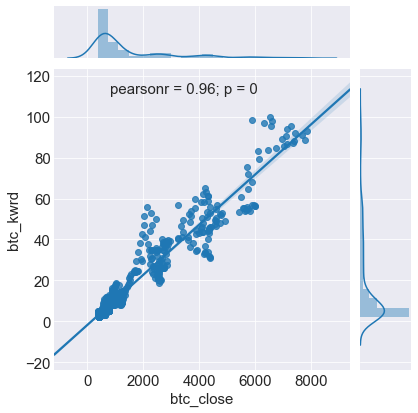

In [25]:
#
# How correlated are the shifted search term frequency with the closing price for bitcoin?
#
sns.jointplot(x="btc_close", y="btc_kwrd", data=df_coins_shifted[year:], kind="reg")

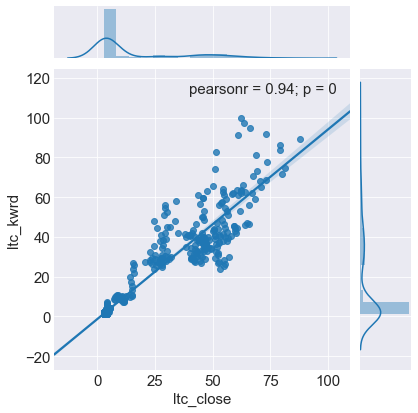

In [26]:
#
# How correlated are the shifted search term frequency with the closing price for litcoin?
#
sns.jointplot(x="ltc_close", y="ltc_kwrd", data=df_coins_shifted[year:], kind="reg")

### Result:

- Both coins remain very correlated with the search term frequency even when they are shitfted by a day! This is very interesting and would suggest that the search term frequency could potentially be used to predict the price direction for either coin.  From the r-squared value, 92.16% of the variance can be explained from the search term frequency for bitcoin even after a day delay.  For litecoin, 88.36% of the variance can be explained from the search term frequency also a day delayed.

- It appears that much of the year 2016 is 'flat' in the sense that not much happens with the price or the search term frequency. 

### Question:

- What happens if only the year 2017 is taken?

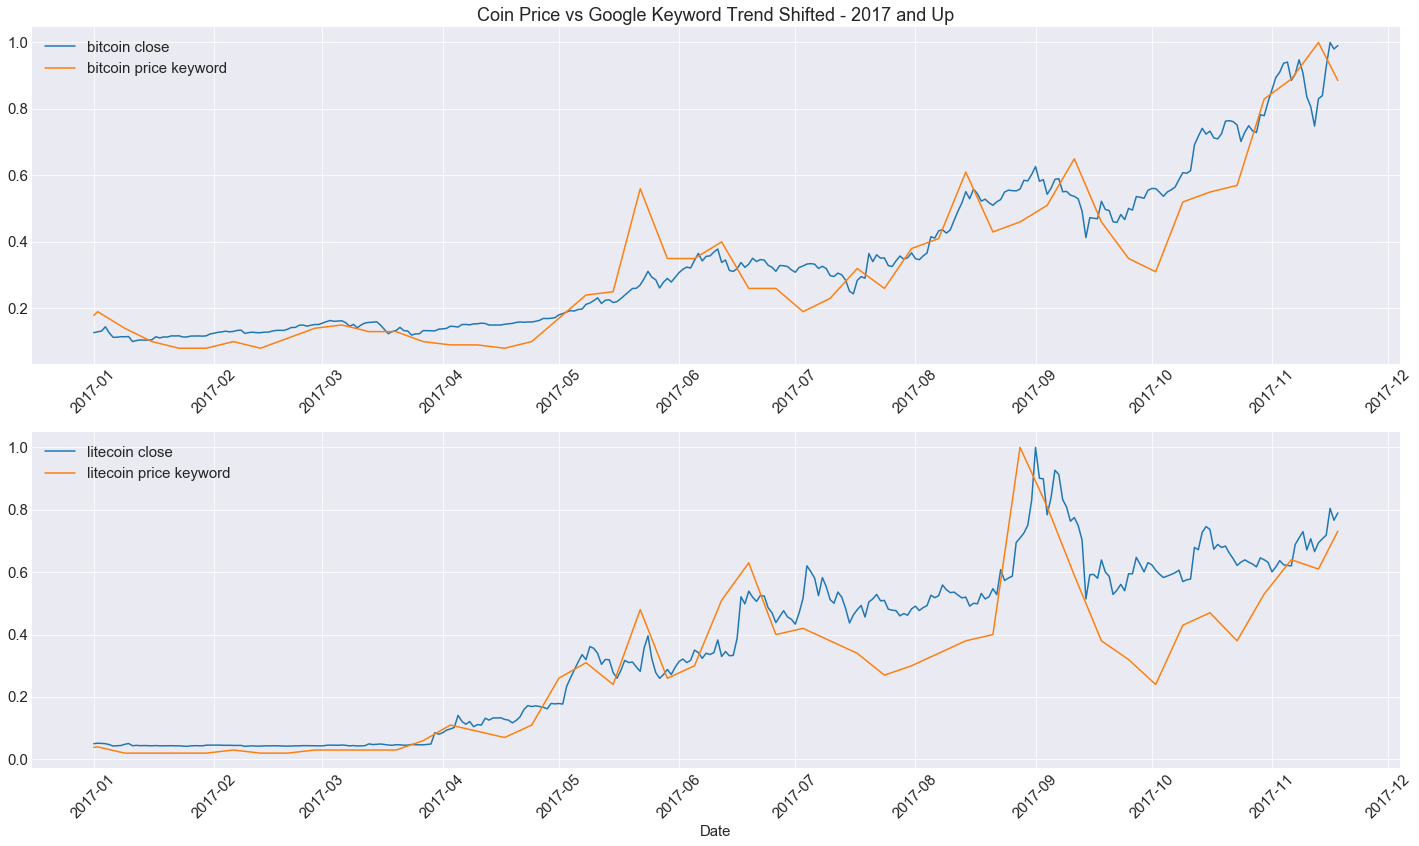

In [27]:
#
# Set the year to 2017.
#
year = pd.to_datetime('2017-01-01')

#
# Plot price vs shifted keyword on the same plot for 2017 and on.
#
plt.rcParams.update({'font.size': 15})
sns.set_style("darkgrid")
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(211)
plt.title("Coin Price vs Google Keyword Trend Shifted - " + str(year.year) + " and Up")
ax.plot(df_coins_shifted[year:].btc_close / df_coins_shifted[year:].btc_close.max())
ax.plot(df_coins_shifted[year:].btc_kwrd / df_coins_shifted[year:].btc_kwrd.max())
ax.legend(["bitcoin close", btc_kwrd[0] + " keyword"], loc="upper left")
plt.xticks(rotation=45)
ax = fig.add_subplot(212)
ax.plot(df_coins_shifted[year:].ltc_close / df_coins_shifted[year:].ltc_close.max())
ax.plot(df_coins_shifted[year:].ltc_kwrd / df_coins_shifted[year:].ltc_kwrd.max())
ax.legend(["litecoin close", ltc_kwrd[0] + " keyword"], loc="upper left")
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.tight_layout()
plt.show()

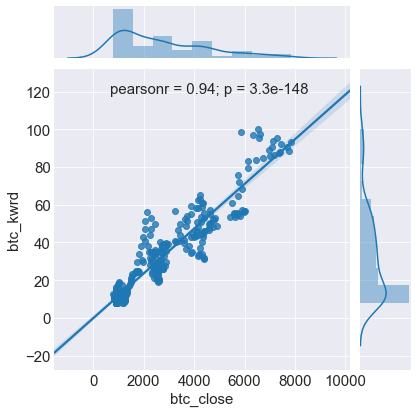

In [28]:
#
# How correlated are the shifted search term frequency with the closing price for bitcoin?
#
sns.jointplot(x="btc_close", y="btc_kwrd", data=df_coins_shifted[year:], kind="reg")

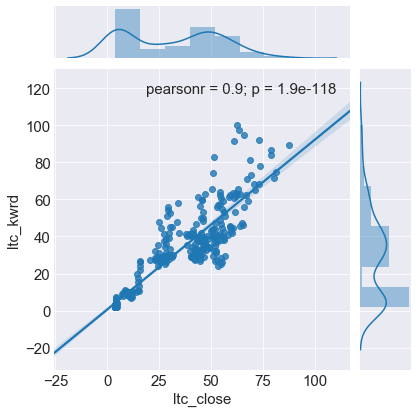

In [29]:
#
# How correlated are the shifted search term frequency with the closing price for litcoin?
#
sns.jointplot(x="ltc_close", y="ltc_kwrd", data=df_coins_shifted[year:], kind="reg")

### Observation:

- The correlation drops for both bitcoin and litecoin when looking only at the year 2017.  They both remain very correlated at 94% and 90% respectively.  

### Question:

- What happens to the correlation if broken down when the data is further broken down into by quarter?

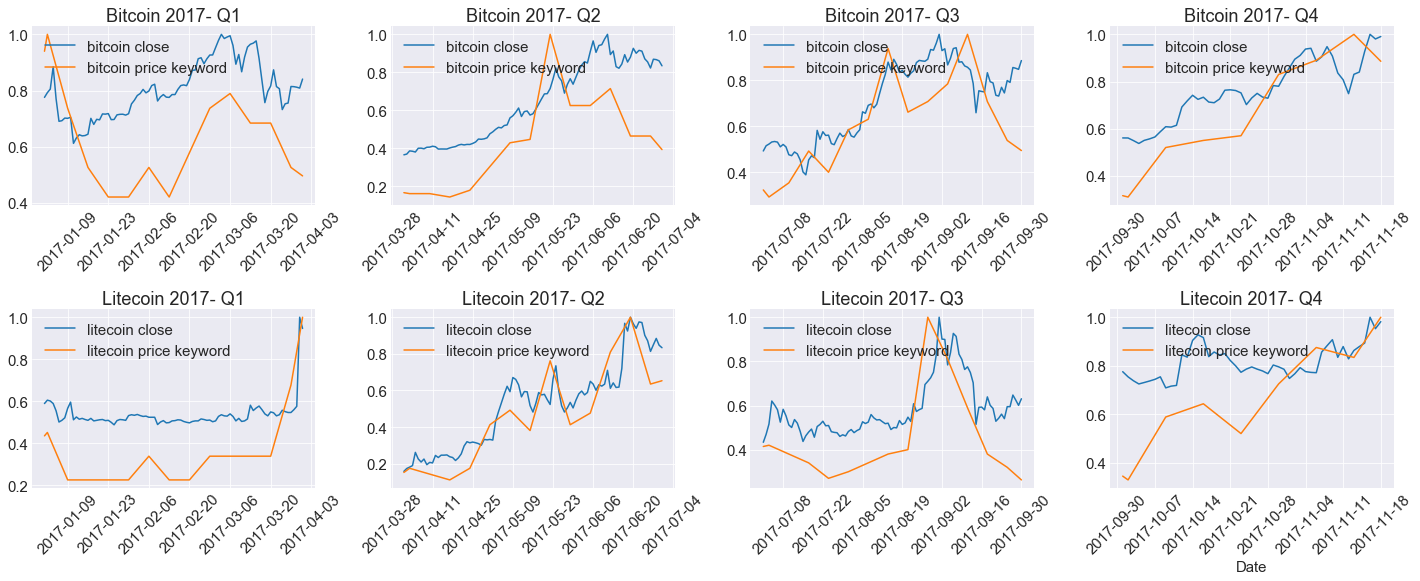

In [30]:
#
# Break the data up by quester.
#
plt.rcParams.update({'font.size': 15})
sns.set_style("darkgrid")
fig = plt.figure(figsize=(20, 15))

for i in range(1,5):
    ax = fig.add_subplot(4, 4, i)
    plt.title("Bitcoin " + str(year.year) + "- Q" + str(i))
    ax.plot(df_coins_shifted[year:].btc_close[df_coins_shifted[year:].index.quarter == i] / df_coins_shifted[year:].btc_close[df_coins_shifted[year:].index.quarter == i].max())
    ax.plot(df_coins_shifted[year:].btc_kwrd[df_coins_shifted[year:].index.quarter == i] / df_coins_shifted[year:].btc_kwrd[df_coins_shifted[year:].index.quarter == i].max())
    ax.legend(["bitcoin close", btc_kwrd[0] + " keyword"], loc="upper left")
    plt.xticks(rotation=45)
   
for i in range(1,5):
    ax = fig.add_subplot(4, 4, 4 + i)
    plt.title("Litecoin " + str(year.year) + "- Q" + str(i))
    ax.plot(df_coins_shifted[year:].ltc_close[df_coins_shifted[year:].index.quarter == i] / df_coins_shifted[year:].ltc_close[df_coins_shifted[year:].index.quarter == i].max())
    ax.plot(df_coins_shifted[year:].ltc_kwrd[df_coins_shifted[year:].index.quarter == i] / df_coins_shifted[year:].ltc_kwrd[df_coins_shifted[year:].index.quarter == i].max())
    ax.legend(["litecoin close", ltc_kwrd[0] + " keyword"], loc="upper left")
    plt.xticks(rotation=45)
plt.xlabel("Date")
plt.tight_layout()
plt.show()

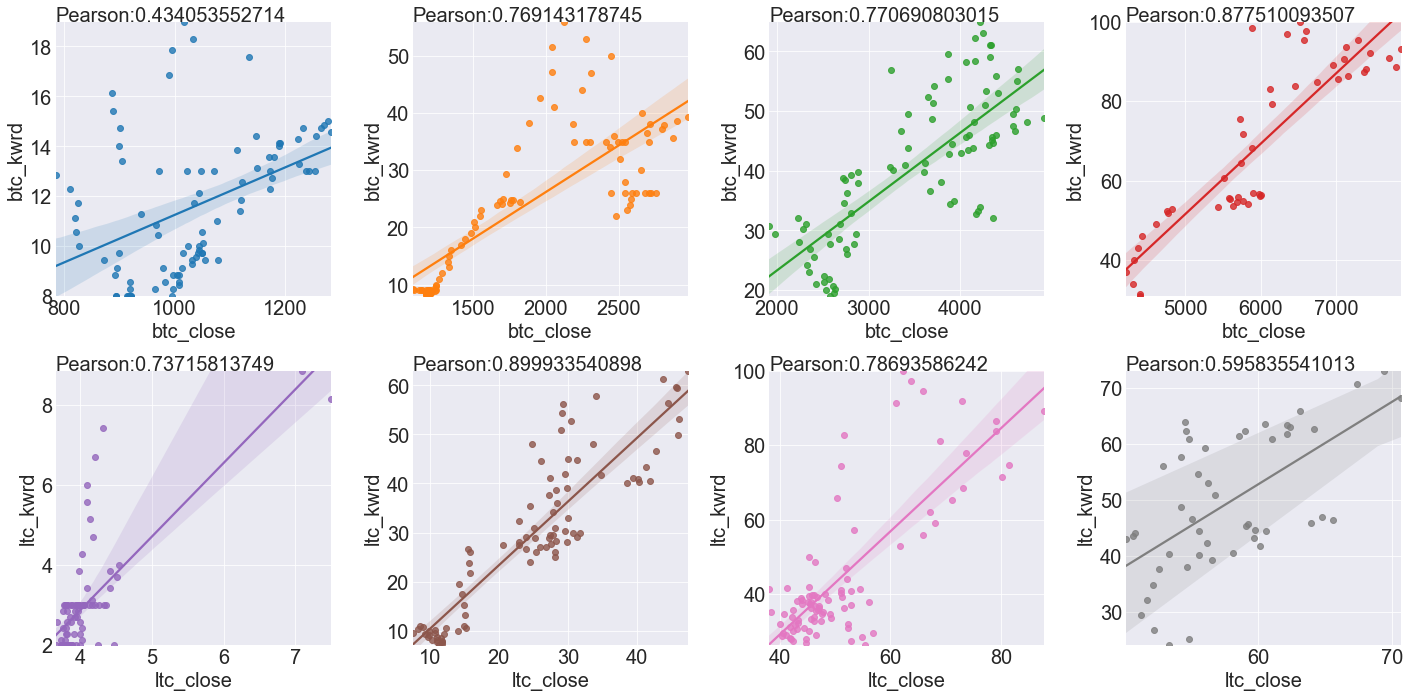

In [31]:
#
# Save a reference to the data in data.
#
new_data = df_coins_shifted[year:]

#
# Look at correlations by quarter.
#
plt.rcParams.update({'font.size': 20})
f, axes = plt.subplots(2, 4, figsize=(20, 10))

#
# Loop through the quarters.
#
for i in range(1, 5):
    data = new_data[df_coins_shifted[year:].index.quarter == i]
    sns.regplot(x="btc_close", y="btc_kwrd", data=data, ax=axes[0][i-1])
    axes[0][i-1].set_xlim([data.btc_close.min(), data.btc_close.max()])
    axes[0][i-1].set_ylim([data.btc_kwrd.min(), data.btc_kwrd.max()])
    axes[0][i-1].text(data.btc_close.min(), data.btc_kwrd.max(), "Pearson:" + str(stats.pearsonr(data.btc_close, data.btc_kwrd)[0]))

for i in range(1, 5):
    data = new_data[df_coins_shifted[year:].index.quarter == i]
    sns.regplot(x="ltc_close", y="ltc_kwrd", data=data, ax=axes[1][i-1])
    axes[1][i-1].set_xlim([data.ltc_close.min(), data.ltc_close.max()])
    axes[1][i-1].set_ylim([data.ltc_kwrd.min(), data.ltc_kwrd.max()])
    axes[1][i-1].text(data.ltc_close.min(), data.ltc_kwrd.max(), "Pearson:" + str(stats.pearsonr(data.ltc_close, data.ltc_kwrd)[0]))
    
plt.tight_layout()
plt.show()

### Conclusion:

- We can see that the correlations vary greatly by quarter.  Bitcoin varrys from 43% to 88%, while litecoin varrys from 60% to 90%.  Based on these results it appears litecoin is more consistantly correlated on a per quarter basis while bitcoin correlates stronger on a macro basis. 